# <span style='color:blue'> LAB 4: </span>
# <span style='color:blue'> CONVOLUTIONAL NEURAL NETWORKS </span>

In [15]:
# Import necessary packages

%matplotlib inline

import matplotlib.pyplot as plt
import torch
import numpy as np

# <span style='color:red'> Part 3: Training CNNs (MNIST Classification example) ------------------------------------</span>

## Prepare Data

In [16]:
# Load MNIST training and testing dataset

# 1000 training features/targets 
train_features = np.load('mnist_train_features.npy') 
train_targets = np.load('mnist_train_targets.npy')

# 100 testing features/targets 
test_features = np.load('mnist_test_features.npy')
test_targets = np.load('mnist_test_targets.npy')

# Print the shape of training/testing features and targets
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


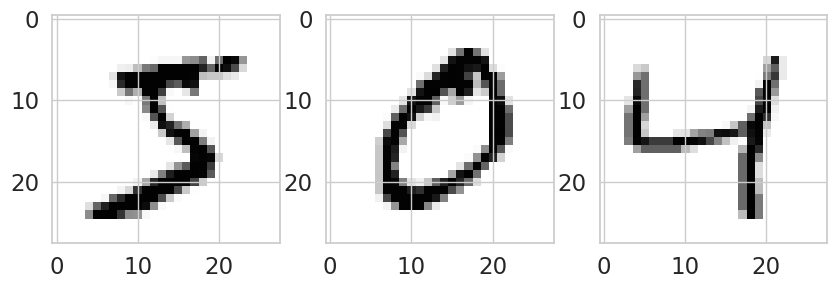

In [17]:
# Let's visualize some training samples

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(train_features[2], cmap = 'Greys')

In [18]:
# Import StandardScaler from scikit-learn

from sklearn.preprocessing import StandardScaler

# First flatten each image into 784 to convert features from 3D -> 2D arrays
train_features_flat = train_features.reshape((1000, 28 * 28))
test_features_flat = test_features.reshape((100, 28 * 28))

# Use standard scaler to scale the flattened images
# Reshape back to 28 x 28 since CNNs accept 2D tensors as inputs
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features_flat).reshape((1000, 28, 28))
test_features = scaler.fit_transform(test_features_flat).reshape((100, 28, 28))

In [5]:
# Taking the first 100 training features/targets as validation dataset
validation_features = train_features[:100]
validation_targets = train_targets[:100]

# Taking the remaining 900 training features/targets as training dataset
train_features = train_features[100:]
train_targets = train_targets[100:]

In [6]:
# Reshape train/validation/test features to according to (N, channels, height, width) where N is number of samples

train_features = np.reshape(train_features, (900, 1, 28, 28))
validation_features = np.reshape(validation_features, (100, 1, 28, 28))
test_features = np.reshape(test_features, (100, 1, 28, 28))

## Define Model

In [7]:
class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()
        
        # First convolution layer (1 channel -> 16 channels, preserve original dimension by adding padding = 2)
        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=16, 
                              kernel_size=5, stride=1, padding=2)
        
        # First max pooling layer with kernel size = 2
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
         
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.cnn2 = torch.nn.Conv2d(in_channels=16, out_channels=32, 
                              kernel_size=5, stride=1, padding=2)
        
        # Second max pooling layer with kernel size = 2
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layer that takes the flattened output of maxpool2 (32, 7 ,7) -> (1568) and output 10 classes
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        
        # input image -> conv1 -> relu -> maxpool1
        conv1_out = torch.nn.functional.relu(self.cnn1(x))       
        pool1_out = self.maxpool1(conv1_out)
        
        # maxpool1 output -> conv2 -> relu -> maxpool2
        conv2_out = torch.nn.functional.relu(self.cnn2(pool1_out))    
        pool2_out = self.maxpool2(conv2_out)
        
        # flatten the maxpool2 output to be used as input into FCN layer
        fcn_input = pool2_out.view(pool2_out.size(0), -1)
    
        # Use the raw output of the fully connected layer as the final output
        output = self.fc1(fcn_input)
        
        return output

## Define Hyperparameters

In [8]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(55)

# Define the model class
model = CNNModel()

# Define learning rate, epochs and batchsize (for mini-batch gradient)
learning_rate = 0.003
epochs = 50
batchsize = 100

# CrossEntropyLoss as loss function and Adam as optimizer
# NOTE: CrossEntropyLoss automatically applies softmax to the output layer 
# so no need to apply manual softmax to the output layer in forward function
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Print modele specific. Add .cuda() to move your model to GPU
model

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

## Identify Tracked Values

In [9]:
# Placeholders for training loss and validation accuracy during training
# Using empty Python list as train_loss_list since we will be appending loss value per iteration
# each iteration = single fwd/bwd pass of a training mini-batch  

train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

## Train Model

In [10]:
import tqdm # Use "for epoch in tqdm.trange(epochs):" to see the progress bar

# Convert train/validation/test sets into torch tensors
# Features -> floating numbers, Target labels -> int64 format
train_inputs = torch.from_numpy(train_features).float()
train_targets = torch.from_numpy(train_targets).long()

validation_inputs = torch.from_numpy(validation_features).float()
validation_targets = torch.from_numpy(validation_targets).long()

testing_inputs = torch.from_numpy(test_features).float()
testing_targets = torch.from_numpy(test_targets).long()

# Use torch.split() function to split the training inputs/targets into mini-batches
# See documentation of torch.split() https://pytorch.org/docs/stable/generated/torch.split.html
train_batches_features = torch.split(train_inputs, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

# Training Loop ---------------------------------------------------------------------------------------

for epoch in range(epochs):
    
    # For each mini-batch number k, grab k-th training feature mini-batch and target mini-batch
    # and perform fwd/bwd pass on the network
    
    for k in range(batch_split_num):
    
        optimizer.zero_grad()
    
        train_batch_outputs = model(train_batches_features[k])

        loss = loss_func(train_batch_outputs, train_batches_targets[k])

        train_loss_list.append(loss.item())

        loss.backward()

        optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------

    with torch.no_grad():

        validation_outputs = model(validation_inputs)

        correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
        print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)

        validation_accuracy_list[epoch] = correct.mean()


Epoch: 0 Validation Accuracy: 78.0%
Epoch: 1 Validation Accuracy: 90.0%
Epoch: 2 Validation Accuracy: 89.0%
Epoch: 3 Validation Accuracy: 93.0%
Epoch: 4 Validation Accuracy: 93.0%
Epoch: 5 Validation Accuracy: 93.0%
Epoch: 6 Validation Accuracy: 93.0%
Epoch: 7 Validation Accuracy: 92.0%
Epoch: 8 Validation Accuracy: 94.0%
Epoch: 9 Validation Accuracy: 93.0%
Epoch: 10 Validation Accuracy: 94.0%
Epoch: 11 Validation Accuracy: 94.0%
Epoch: 12 Validation Accuracy: 93.0%
Epoch: 13 Validation Accuracy: 94.0%
Epoch: 14 Validation Accuracy: 94.0%
Epoch: 15 Validation Accuracy: 94.0%
Epoch: 16 Validation Accuracy: 94.0%
Epoch: 17 Validation Accuracy: 94.0%
Epoch: 18 Validation Accuracy: 94.0%
Epoch: 19 Validation Accuracy: 95.0%
Epoch: 20 Validation Accuracy: 95.0%
Epoch: 21 Validation Accuracy: 95.0%
Epoch: 22 Validation Accuracy: 95.0%
Epoch: 23 Validation Accuracy: 95.0%
Epoch: 24 Validation Accuracy: 95.0%
Epoch: 25 Validation Accuracy: 95.0%
Epoch: 26 Validation Accuracy: 95.0%
Epoch: 27 V

## Visualize & Evaluate Model

In [11]:
# Import seaborn for prettier plot with whitegrid style

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1.5)

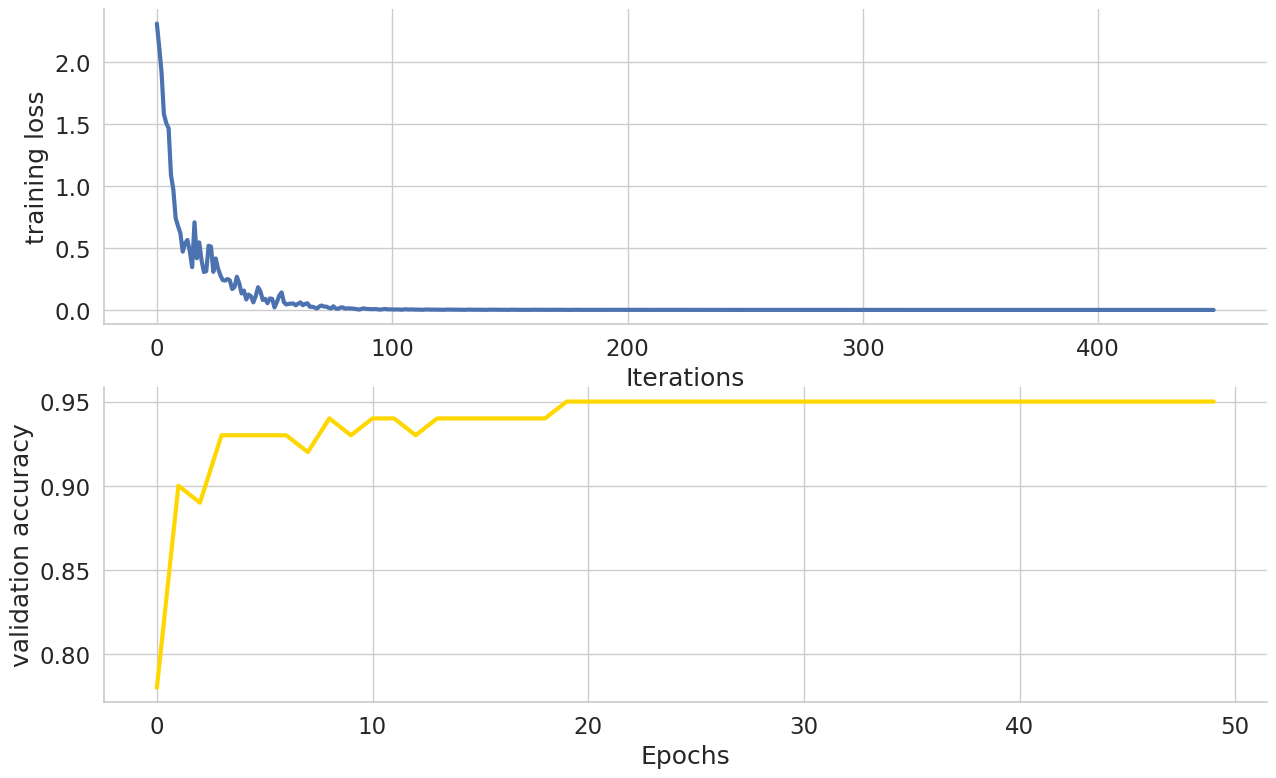

In [12]:
# Plot training loss and validation accuracy throughout the training

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("Iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.xlabel("Epochs")
sns.despine()

In [13]:
# Compute the testing accuracy 

with torch.no_grad():
    
    y_pred_test = model(testing_inputs)
     
    correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()))

Testing Accuracy: 0.96
